## 1.Importing Libraries

In [41]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 975.2 kB/s eta 0:02:09
   ---------------------------------------- 0.4/124.9 MB 3.4 MB/s eta 0:00:37
   ---------------------------------------- 0.6/124.9 MB 4.8 MB/s eta 0:00:27
   ---------------------------------------- 1.3/124.9 MB 7.0 MB/s eta 0:00:18
    --------------------------------------- 1.8/124.9 MB 8.1 MB/s eta 0:00:16
    --------------------------------------- 2.3/124.9 MB 8.3 MB/s eta 0:00:15
    --------------------------------------- 2.8/124.9 MB 8.6 MB/s eta 0:00:15
   - -------------------------------------- 3.2/124.9 MB 8.5 MB/s eta 0:00:15
   - -------------------------------------- 3.5/124.9 MB 8.5 MB/s eta 0:00:15
   - -------------------------------------- 3.7/124.9 MB 7.8 MB/s eta 0:00:16
   - -------------------------------------- 3.8/124.9 MB 7.3 MB/s eta 0:00:1

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

## 2.Display Setting

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

## 3.Getting the Data

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")


In [5]:
train_df.head(3)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117


### 3.1 Split Data

In [6]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [7]:
X_train, y_train = split_data(train_df)

In [8]:
X_val, y_val = split_data(val_df)
print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [9]:
X_test, y_test = split_data(test_df)
print(X_test.shape, y_test.shape)

(200, 9) (200,)


### 3.2 Meta-info

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [11]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [ col for col in X_train.columns if (col not in num_cols) and (col not in dt_cols)]

In [12]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [13]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [14]:

preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [15]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


In [16]:

preprocessor.fit_transform(X_train).shape

(640, 33)

## 5.Model Selection

In [17]:

algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [18]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [19]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [20]:

def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

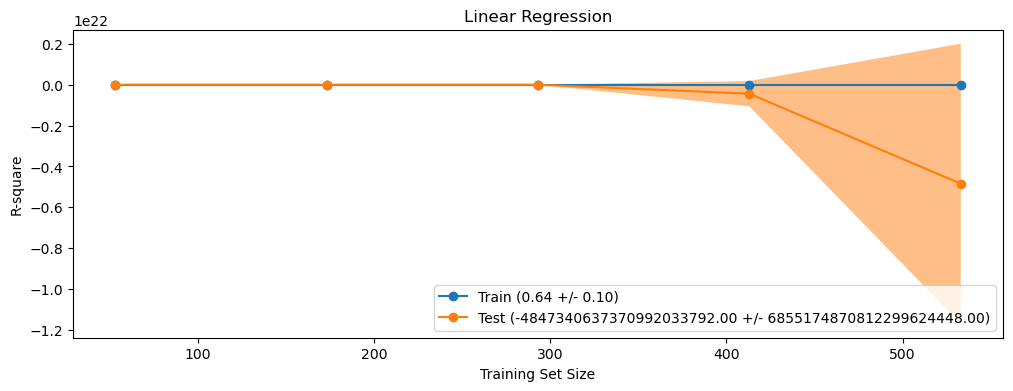

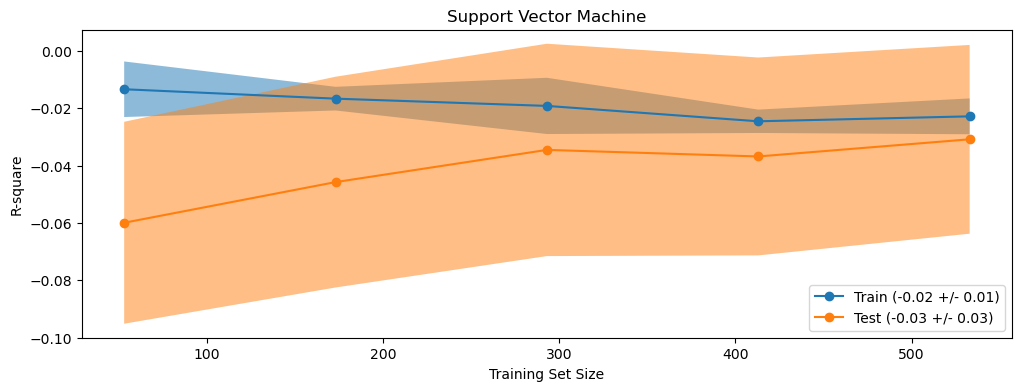

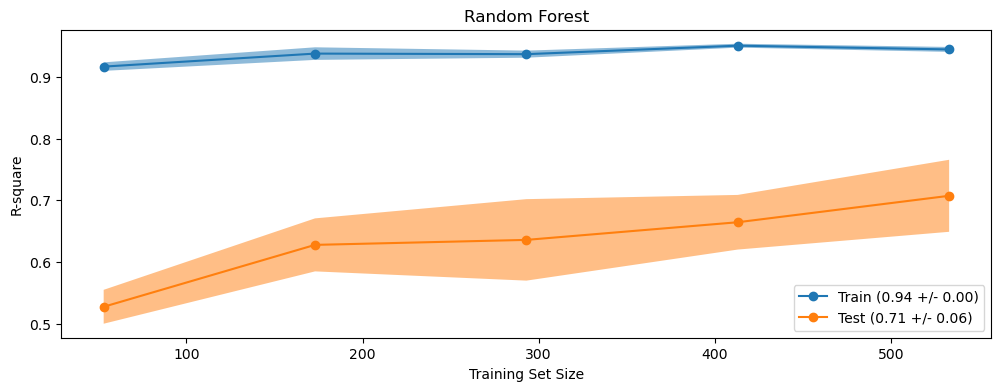

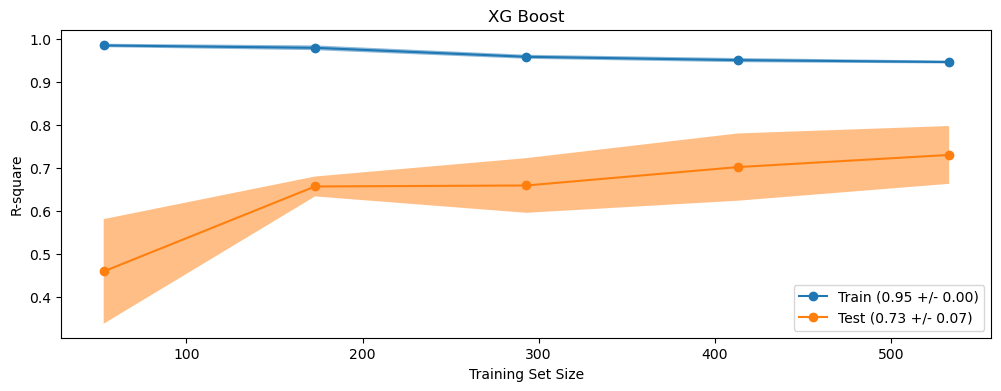

In [21]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

## 6.Model Training

In [22]:

model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [23]:

model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7.Model Evaluation

In [24]:

def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [25]:

print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9556320685088405


In [26]:

print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.7063366395314226


## 8.Model Persistennce

In [27]:

joblib.dump(model, "model.joblib")

['model.joblib']

In [28]:

saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [29]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.7063366395314226